In [1]:
import sys

import os
import json
import time
import argparse

import pandas as pd
import numpy as np


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchinfo import summary

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

import wandb

sys.path.append('./../../../src/')

from utils import *
from utils_torch import * 
from MHCCBM import *
from PGPredictor_CNN import *
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

## Flank CV

<AxesSubplot: xlabel='flank', ylabel='value'>

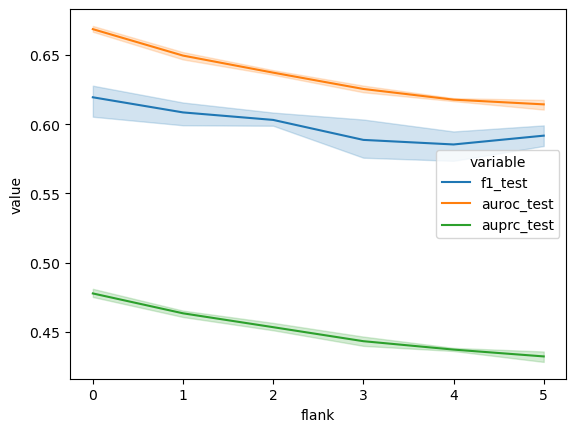

In [135]:
plot_df = pd.read_csv('./../results/flanks_cv/flanks_cv_result.csv')
plot_df = plot_df[['flank','f1_test','auroc_test','auprc_test']]
sns.lineplot(data=plot_df.melt('flank'), x='flank', y='value', hue='variable')

<AxesSubplot: xlabel='flank', ylabel='value'>

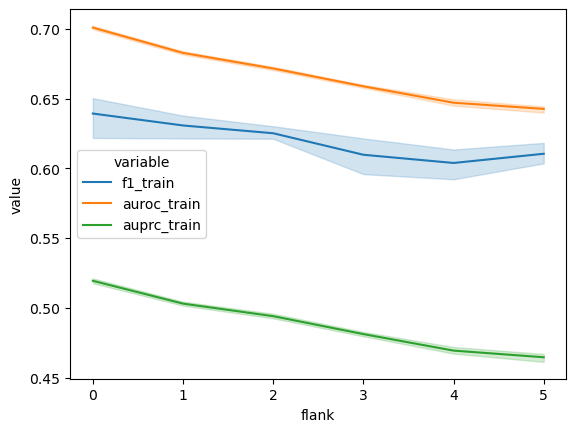

In [136]:
plot_df = pd.read_csv('./../results/flanks_cv/flanks_cv_result.csv')
plot_df = plot_df[['flank','f1_train','auroc_train','auprc_train']]
sns.lineplot(data=plot_df.melt('flank'), x='flank', y='value', hue='variable')

<AxesSubplot: xlabel='flank', ylabel='value'>

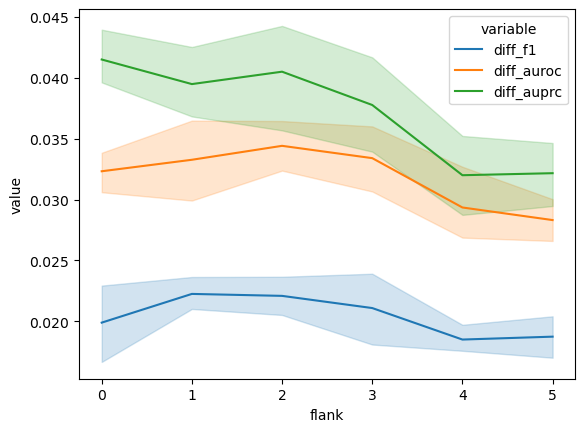

In [141]:
cv_result_df = pd.read_csv('./../results/flanks_cv/flanks_cv_result.csv')
cv_result_df['diff_f1'] = cv_result_df['f1_train'] - cv_result_df['f1_test']
cv_result_df['diff_auroc'] = cv_result_df['auroc_train'] - cv_result_df['auroc_test']
cv_result_df['diff_auprc'] = cv_result_df['auprc_train'] - cv_result_df['auprc_test']

plot_df = cv_result_df[['flank','diff_f1','diff_auroc','diff_auprc']]
sns.lineplot(data=plot_df.melt('flank'), x='flank', y='value', hue='variable')


## PG predictor results

In [9]:
# load embedding
MAPP_embedded_df_ = pd.read_csv('./../../../data/PG/esm1b/MAPP/MAPP_'+str(0)+'flank.csv',index_col=0)

for flank in range(6):
    print("flank: ", flank)
    
    embedding_df = pd.read_csv('./../../../data/PG/esm1b/flank'+str(flank)+'_peptides_esm1b.csv',index_col=0)

    # Make  and y
    X = embedding_df.drop(['peptide','hit'],axis=1).to_numpy()

    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X.squeeze())

    # scale MAPP embeddings
    MAPP_embedded = MAPP_embedded_df_.drop(['peptide','y'],axis=1).to_numpy()
    MAPP_embedded = scaler.transform(MAPP_embedded)
    MAPP_embedded = torch.tensor(MAPP_embedded, dtype=torch.float32).reshape(MAPP_embedded.shape[0],1,-1)

    y = MAPP_embedded_df_['y']

    # load model
    model = torch.load('./../results/final_model/flank'+str(flank)+'_PGpred_65iter.pt')

    with torch.no_grad():
        y_pred = torch.sigmoid(model(MAPP_embedded)) 

    y_pred = y_pred.reshape(-1)

    #### performance of PGPredictor
    fpr, tpr, _ = roc_curve(y,y_pred)
    auroc = auc(fpr, tpr)
    print("auroc without flank: ", auroc)

    precision, recall, _ = precision_recall_curve(y,y_pred)
    auprc = auc(recall, precision)
    print("auprc without flank: ", auprc)




flank:  0
auroc without flank:  0.46207661562350005
auprc without flank:  0.319835207434351
flank:  1
auroc without flank:  0.5155976208855986
auprc without flank:  0.3470481376309178
flank:  2
auroc without flank:  0.5415373998287993
auprc without flank:  0.3716162835734459
flank:  3
auroc without flank:  0.5368242936865877
auprc without flank:  0.3607291450882073
flank:  4
auroc without flank:  0.4624199017476184
auprc without flank:  0.3101031177013854
flank:  5
auroc without flank:  0.4922723019856182
auprc without flank:  0.33430836149478593


In [2]:
# With flanks
for flank in range(6):
    print("flank: ", flank)
    
    # load embedding
    MAPP_embedded_df_ = pd.read_csv('./../../../data/PG/esm1b/MAPP/MAPP_'+str(flank)+'flank.csv',index_col=0)

    embedding_df = pd.read_csv('./../../../data/PG/esm1b/flank'+str(flank)+'_peptides_esm1b.csv',index_col=0)

    # Make  and y
    X = embedding_df.drop(['peptide','hit'],axis=1).to_numpy()

    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X.squeeze())

    # scale MAPP embeddings
    MAPP_embedded = MAPP_embedded_df_.drop(['peptide','y'],axis=1).to_numpy()
    MAPP_embedded = scaler.transform(MAPP_embedded)
    MAPP_embedded = torch.tensor(MAPP_embedded, dtype=torch.float32).reshape(MAPP_embedded.shape[0],1,-1)

    y = MAPP_embedded_df_['y']

    # load model
    model = torch.load('./../results/final_model/flank'+str(flank)+'_PGpred_65iter.pt')

    with torch.no_grad():
        y_pred = torch.sigmoid(model(MAPP_embedded)) 

    y_pred = y_pred.reshape(-1)

    #### performance of PGPredictor
    fpr, tpr, _ = roc_curve(y,y_pred)
    auroc = auc(fpr, tpr)
    print("auroc flank: ", auroc)

    precision, recall, _ = precision_recall_curve(y,y_pred)
    auprc = auc(recall, precision)
    print("auprc flank: ", auprc)




flank:  0
auroc flank:  0.46207661562350005
auprc flank:  0.319835207434351
flank:  1
auroc flank:  0.5257449109822805
auprc flank:  0.36100274101053403
flank:  2
auroc flank:  0.5404352124857056
auprc flank:  0.37102989556398314
flank:  3
auroc flank:  0.5243151419704888
auprc flank:  0.3617457592479581
flank:  4
auroc flank:  0.4772721139745323
auprc flank:  0.3248393635982101
flank:  5
auroc flank:  0.5179373635537192
auprc flank:  0.3444281172361323


## final model train result

<AxesSubplot: xlabel='flank', ylabel='value'>

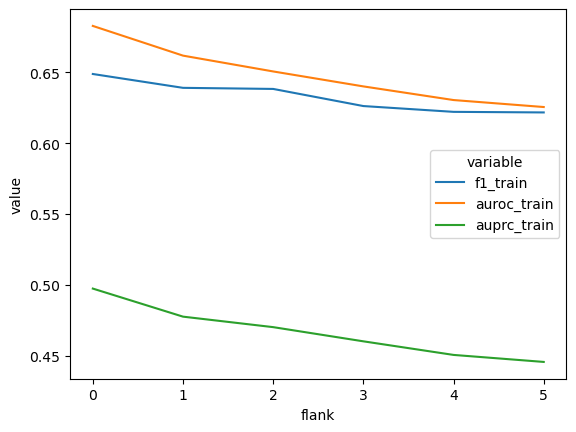

In [133]:
train_metrics_df = []
for flank in range(6):
    train_metrics_df = train_metrics_df + [pd.read_csv('./../results/final_model/flank'+str(flank)+'_PGpred_65iter.csv')]
    
train_metrics_df = pd.concat(train_metrics_df)
train_metrics_df['flank'] = list(range(6))

train_metrics_df = train_metrics_df[['f1_train','auroc_train','auprc_train','flank']].melt('flank')

sns.lineplot(data=train_metrics_df, x='flank', y='value', hue='variable')

    
    